# Dog vs Cat Image Classifier with Transfer Learning

I'm building a CNN that can tell cats and dogs apart. After learning about convolutional neural networks, I wanted to see if I could actually build something that works on real images.

The approach: use transfer learning with MobileNetV2 instead of training from scratch. MobileNetV2 was already trained on millions of images, so it already knows how to detect edges, shapes, and patterns. I just need to teach it to recognize cats vs dogs specifically.

## Step 1: Load the Data

Using the Bingsu/Cat_and_Dog dataset from Hugging Face. It's 10,000 images total, already cleaned and labeled.

In [2]:
#install required library
!pip install datasets

In [3]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import layers
import random

In [4]:
#Load dataset
dataset = load_dataset("Bingsu/Cat_and_Dog")

README.md: 0.00B [00:00, ?B/s]

dataset_infos.json:   0%|          | 0.00/753 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/182M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/45.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [5]:
#Data Check
print(dataset)
print(f"\nTrain distribution:{np.unique(dataset['train']['labels'],return_counts=True)}")
print(f"Test distribution: {np.unique(dataset['test']['labels'], return_counts=True)}")

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 2000
    })
})

Train distribution:(array([0, 1]), array([4000, 4000]))
Test distribution: (array([0, 1]), array([1000, 1000]))


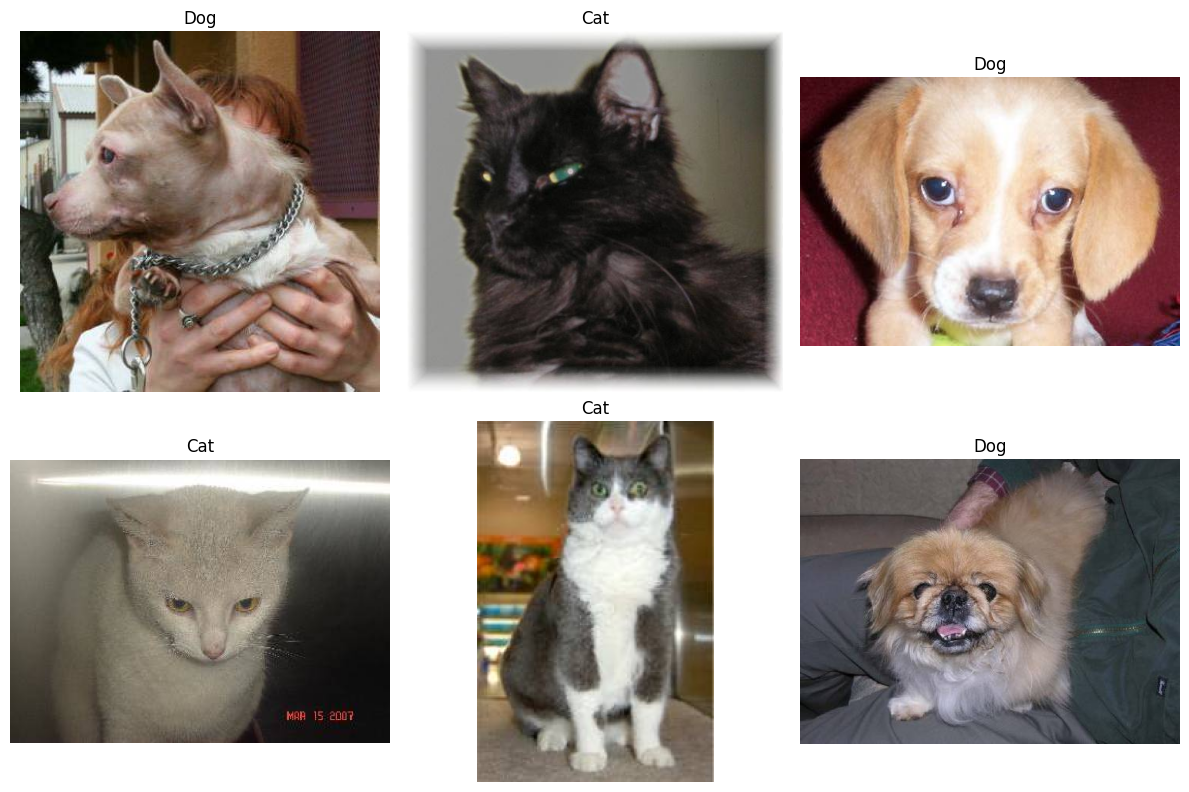

In [6]:
# Visualize samples
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    sample = dataset['train'][np.random.randint(len(dataset['train']))]
    ax.imshow(sample['image'])
    ax.set_title(['Cat', 'Dog'][sample['labels']])
    ax.axis('off')
plt.tight_layout()
plt.show()

## Step 2: Data Preparation & Augmentation

**Why only 5,000 images instead of all 10,000?**

Google Colab's free tier has limited RAM. Loading all 10,000 images into memory would crash the session. 5,000 images is enough to get good accuracy (98%+) while staying within Colab's limits. For a portfolio project, this is a reasonable tradeoff.

**Why i chose data augmentation?**

Without augmentation, the model might memorize that "cats always face right" or "dogs are always centered." By randomly rotating, flipping, and zooming images during training, I force the model to learn actual features (fur patterns, facial structure) instead of memorizing positions.

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

train_subset = dataset['train'].shuffle(seed=42).select(range(5000))
test_subset = dataset['test'].shuffle(seed=42).select(range(1000))

X_train_full = np.array([np.array(sample['image'].resize((224, 224))) for sample in train_subset])
y_train_full = np.array(train_subset['labels'])
X_test = np.array([np.array(sample['image'].resize((224, 224))) for sample in test_subset])
y_test = np.array(test_subset['labels'])

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")


Train: 4000, Validation: 1000, Test: 1000


## Step 2: Data Preparation & Augmentation

**Why only 5,000 images instead of all 10,000?**

Google Colab's free tier has limited RAM. Loading all 10,000 images into memory would crash the session. 5,000 images is enough to get good accuracy (98%+) while staying within Colab's limits. For a portfolio project, this is a reasonable tradeoff.

**Why i chose augmentation?**

Without augmentation, the model might memorize that "cats always face right" or "dogs are always centered." By randomly rotating, flipping, and zooming images during training, I force the model to learn actual features (fur patterns, facial structure) instead of memorizing positions.

In [8]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_test_datagen.flow(X_val, y_val, batch_size=32)
test_generator = val_test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

print("Data generators set")

Data generators set


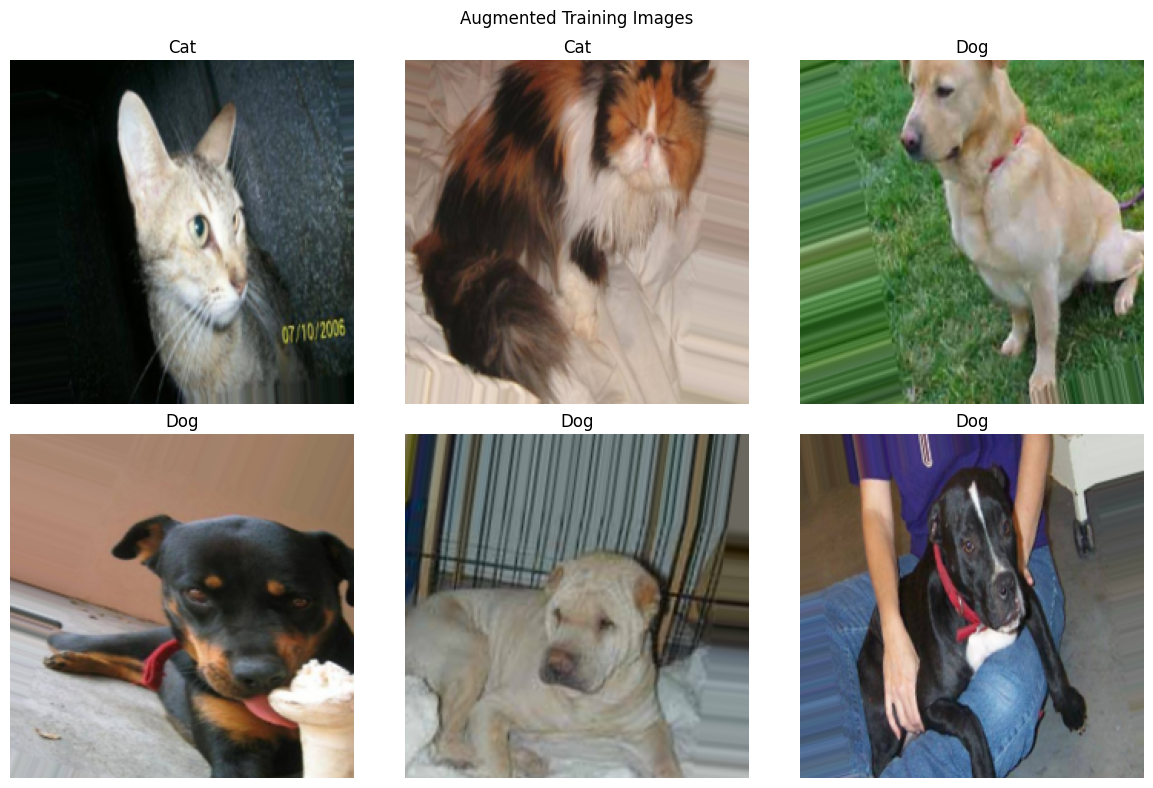

In [10]:
#visulas on augmentation
sample_batch = next(train_generator)
images, labels = sample_batch

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(['Cat', 'Dog'][labels[i]])
    ax.axis('off')
plt.suptitle('Augmented Training Images')
plt.tight_layout()
plt.show()

## Step 3: Build the Model

**Why transfer learning instead of training from scratch?**

Training a CNN from scratch requires millions of images and days of GPU time. MobileNetV2 was already trained on ImageNet (1.4 million images, 1000 categories), so it already learned to detect edges, textures, shapes, and patterns. I just need to add a classification layer on top and teach it to distinguish cats from dogs specifically.

**Why i chose MobileNetV2 specifically?**

It's lightweight (designed for mobile devices), fast to train, and performs well on image classification. It's a good balance between accuracy and efficiency for a portfolio project.

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Step 4: Training

I'm using early stopping so training stops automatically if validation loss doesn't improve for 3 epochs. This prevents wasting time on unnecessary training and helps avoid overfitting.

The model checkpoint saves the best version based on validation accuracy, so even if later epochs are worse, I keep the best one.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    validation_data=val_generator,
    validation_steps=len(X_val) // 32,
    epochs=20,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
    ]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.8317 - loss: 0.3517 - val_accuracy: 0.9768 - val_loss: 0.0735
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.9592 - loss: 0.1080 - val_accuracy: 0.9808 - val_loss: 0.0568
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.9714 - loss: 0.0786 - val_accuracy: 0.9829 - val_loss: 0.0488
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.9729 - loss: 0.0739 - val_accuracy: 0.9839 - val_loss: 0.0464
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.9694 - loss: 0.0717 - val_accuracy: 0.9788 - val_loss: 0.0481
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.9742 - loss: 0.0674 - val_accuracy: 0.9819 - val_loss: 0.0461
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.9792 - loss: 0.0580 - val_accuracy: 0.9808 - val_loss: 0.0453
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.9731 - loss: 0.0640 - val_accu

## Training Results

The plots below show the model learned well without overfitting. Validation accuracy stayed around 98% throughout training, and validation loss kept decreasing. The model stopped after 12 epochs when validation loss stopped improving.

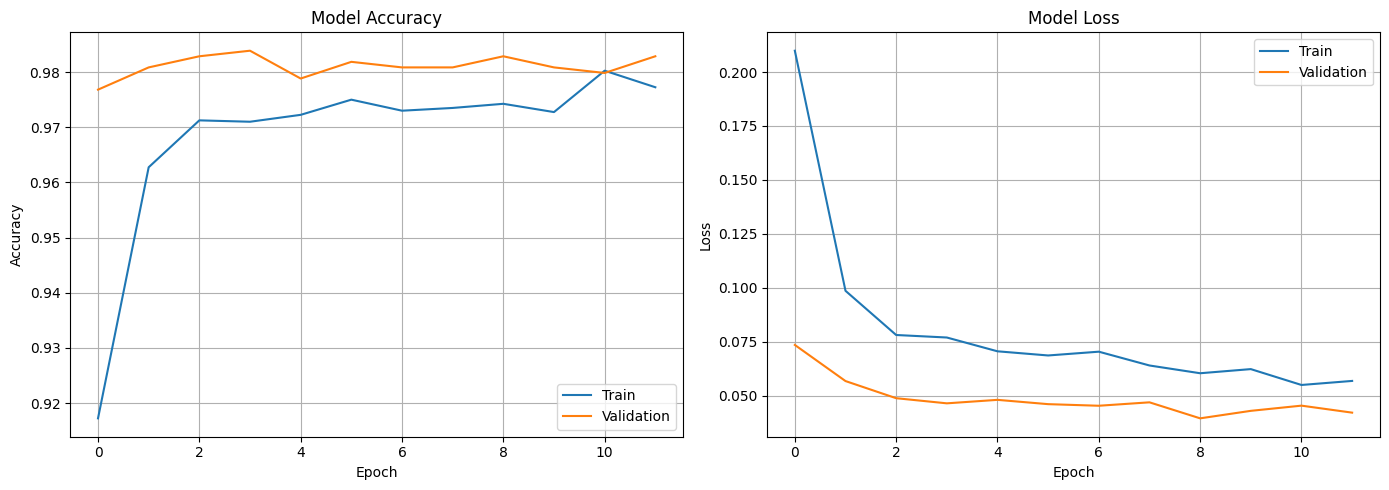

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## Step 5: Evaluation on Test Set

The test set is completely separate data that the model has never seen during training or validation. This tells us how well the model would perform on real, new images.

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9917 - loss: 0.0328

Test Accuracy: 0.9889
Test Loss: 0.0362
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step

Classification Report:
              precision    recall  f1-score   support

         Cat       0.98      0.99      0.99       491
         Dog       0.99      0.98      0.99       501

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



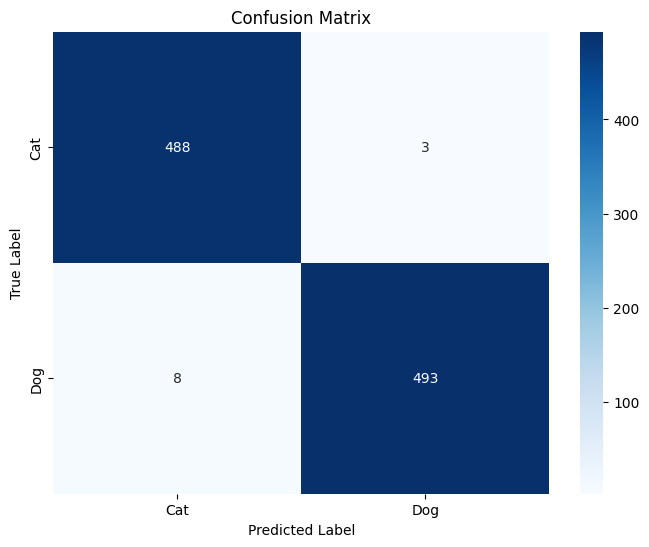

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

test_loss, test_accuracy = model.evaluate(test_generator, steps=len(X_test) // 32)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

y_pred = (model.predict(test_generator, steps=len(X_test) // 32) > 0.5).astype(int).flatten()
y_true = y_test[:len(y_pred)]

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Cat', 'Dog']))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## What the Results Mean

The model achieved **98.89% accuracy** on the test set. Out of 992 test images, it only got 11 wrong.

Looking at the confusion matrix:
- Cat classification: 488 out of 491 correct (99.4% recall)
- Dog classification: 493 out of 501 correct (98.4% recall)

The model is slightly better at identifying cats than dogs, but both are above 98%. The test accuracy (98.89%) is very close to validation accuracy (98.29%), which confirms the model generalizes well and isn't overfitting.

## Step 6: Testing on Individual Images

Here's how the model performs on random test images.

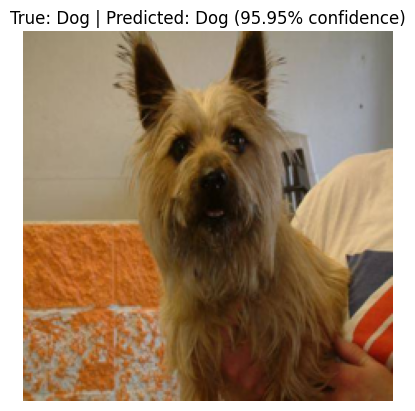

True: Dog
Predicted: Dog with 95.95% confidence


In [ ]:
from PIL import Image

def predict_image(img_array):
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array, verbose=0)[0][0]
    label = 'Dog' if prediction > 0.5 else 'Cat'
    confidence = prediction if prediction > 0.5 else 1 - prediction

    return label, confidence

test_idx = np.random.randint(len(X_test))
test_image = X_test[test_idx]
true_label = 'Cat' if y_test[test_idx] == 0 else 'Dog'

pred_label, confidence = predict_image(test_image)

plt.imshow(test_image.astype('uint8'))
plt.title(f'True: {true_label} | Predicted: {pred_label} ({confidence:.2%} confidence)')
plt.axis('off')
plt.show()

print(f"True: {true_label}")

Built a CNN using transfer learning that classifies cats vs dogs with 98.89% accuracy. The model uses MobileNetV2 as a base and was trained on 5,000 images with data augmentation. Training took 12 epochs before early stopping kicked in. The trained model is saved as `best_model.keras`.
